# Deteksi Hepatitis MLP

## Import Library

In [45]:
# Data Manipulation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Data Visualization
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import missingno as msno
import seaborn as sns

# MLP
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# Utils
import json
from keras.utils import np_utils

## Load Data

In [46]:
df = pd.read_csv('HepatitisDataset.csv')
df.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  615 non-null    int64  
 1   Category    615 non-null    object 
 2   Age         615 non-null    int64  
 3   Sex         615 non-null    object 
 4   ALB         614 non-null    float64
 5   ALP         597 non-null    float64
 6   ALT         614 non-null    float64
 7   AST         615 non-null    float64
 8   BIL         615 non-null    float64
 9   CHE         615 non-null    float64
 10  CHOL        605 non-null    float64
 11  CREA        615 non-null    float64
 12  GGT         615 non-null    float64
 13  PROT        614 non-null    float64
dtypes: float64(10), int64(2), object(2)
memory usage: 67.4+ KB


## Data Preprocessing

### Remove Unnecessary Columns

In [48]:
df = df.drop('Unnamed: 0', axis=1)

### Missing Values

<AxesSubplot:>

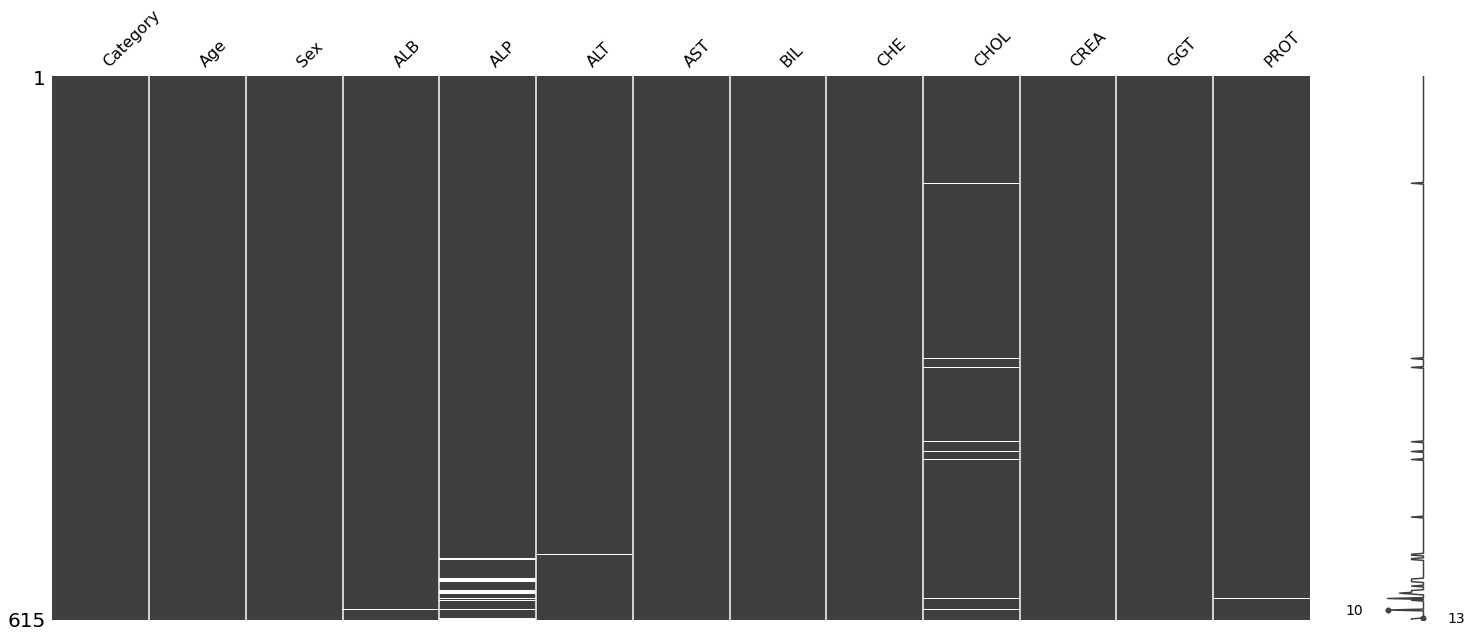

In [49]:
msno.matrix(df)

In [50]:
df.isnull().groupby('Category').sum()

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
Category,,,,,,,,,,,,
False,0,0,1,18,1,0,0,0,10,0,0,1


In [51]:
df.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

In [52]:
df.isnull().sum() * 100 / len(df)

Category    0.000000
Age         0.000000
Sex         0.000000
ALB         0.162602
ALP         2.926829
ALT         0.162602
AST         0.000000
BIL         0.000000
CHE         0.000000
CHOL        1.626016
CREA        0.000000
GGT         0.000000
PROT        0.162602
dtype: float64

Karena data yang kosong atau null terbilang sedikit kami memutuskan untuk menghapus kolom yang memiliki missing values.

In [53]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.isnull().sum()

Category    0
Age         0
Sex         0
ALB         0
ALP         0
ALT         0
AST         0
BIL         0
CHE         0
CHOL        0
CREA        0
GGT         0
PROT        0
dtype: int64

### Convert to Numerical Data

In [54]:
df['Sex'].replace('m', 1, inplace=True)
df['Sex'].replace('f', 0, inplace=True)
df['Category'].replace({"1=Hepatitis", "2=Fibrosis", "3=Cirrhosis"}, 1, inplace=True)
df['Category'].replace({"0=Blood Donor", "0s=suspect Blood Donor"}, 0, inplace=True)

In [55]:
df.tail()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
584,1,58,0,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
585,1,59,0,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
586,1,62,0,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
587,1,64,0,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3
588,1,64,0,29.0,87.3,3.5,99.0,48.0,1.66,3.63,66.7,64.2,82.0


## Data Visualization

### Macam-macam Feature

Terdapat beberapa macam feature yaitu:

#### Caterogical Feature

Categorical feature adalah feature yang tediri dari dua kategori. Misalnya, jenis kelamin yang mana memiliki 2 kategori yaitu pria dan wanita. Feature ini biasanya juga disebut sebagai Numerical Feature

#### Ordinal Feature

Ordinal feature mirip dengan categorical feature namun feature ini dapat diurutkan nilainya. Misalnya kepuasan konsumen yang memiliki 4 kategori yang dapat dirutkan yaitu tidak puas, puas sedang, puas dan sangat puas.

#### Continuous Feature

Continous feature adalah feature yang berisi angka. Misalnya, umur.

### Feature Analyze

### Category Visualization

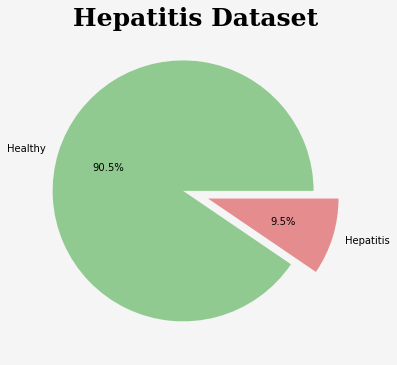

In [56]:
fig, ax = plt.subplots(1,1, figsize = (6, 6))
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax.pie(df['Category'].value_counts().values, 
            labels=['Healthy', 'Hepatitis'],
            autopct='%1.1f%%', explode=[0.1,  0.1], 
            colors=['tab:green', 'tab:red'])

for piece in ax.axes.patches:
    piece.set_alpha(0.5)

plt.title('Hepatitis Dataset', {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})

plt.show()

#### Age -> Continuous Feature

In [57]:
print('Oldest Age:', df['Age'].max(),'Years')
print('Youngest Age:', df['Age'].min(),'Years')
print('Average Age:', df['Age'].mean(),'Years')

Oldest Age: 77 Years
Youngest Age: 23 Years
Average Age: 47.41765704584041 Years


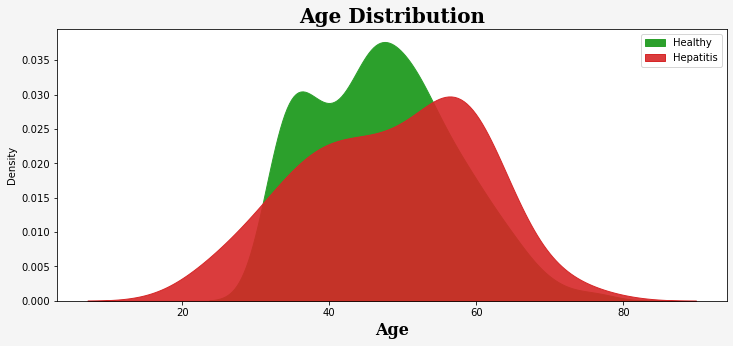

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (12,5))
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

sns.kdeplot('Age', data=df[df.Category==0], ax=ax, shade=True, color='tab:green', alpha=1, label='Healthy')
sns.kdeplot('Age', data=df[df.Category==1], ax=ax, shade=True, color='tab:red', alpha=0.9, label='Hepatitis')

ax.legend()
ax.set_xlabel('Age', {'font':'Serif', 'fontsize':16,'fontweight':'bold', 'color':'black'})

plt.title('Age Distribution', {'font':'Serif', 'fontsize':20,'fontweight':'bold', 'color':'black'})

plt.show()

#### Sex -> Categorical Feature

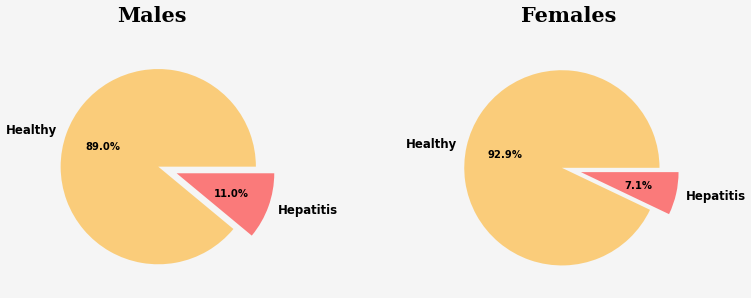

In [59]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])

axes = [ax1,ax2]

for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------    
#ax1
ax1_plot = ax1.pie(df[df.Sex == 1].groupby('Category').Category.count().values, 
                   labels=['Healthy', 'Hepatitis'],
                    autopct='%1.1f%%', explode=[0.1,  0.1], 
                   colors=['orange', 'red', 'green', 'purple'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax1_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax1_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

    
fig.text(0.1, 0.75, 'Males',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#------------------------------------------------------------    
#ax2
ax2_plot = ax2.pie(df[df.Sex == 0].groupby('Category').Category.count().values, 
                   labels=['Healthy', 'Hepatitis'],
                    autopct='%1.1f%%', explode=[0.1,  0.1], 
                   colors=['orange', 'red', 'green', 'purple'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax2_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax2_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.38, 0.75, 'Females',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25}) 
plt.show()

#### ALB, ALP, ALT, AST, BIL, CHE, CHOL, CREA, GGT, PROT -> Continous Feature

In [60]:
# TODO

### Correlation Matrix Between Independent Variables

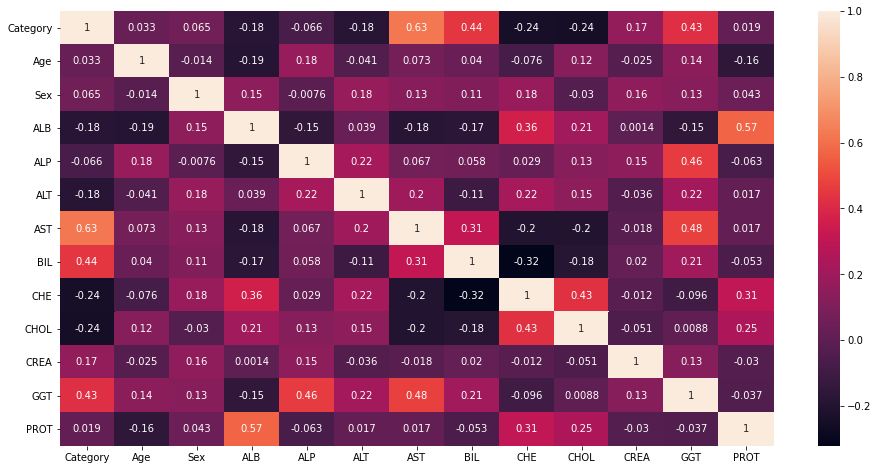

In [61]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(),annot=True)
plt.show()

In [62]:
pd.DataFrame([["0 < r <= 0.19", "Very Low Correlation"],["0.2 <= r <= 0.39", "Low Correlation"], ["0.4 < r <= 0.59", "Modderate Correlation"], ["0.6 < r <= 0.79", "High Correlation"], ["0.8 < r <= 1.0", "Very High Correlation"] ], columns=['Scale of Correlation', 'Value'])

,Scale of Correlation,Value
0,0 < r <= 0.19,Very Low Correlation
1,0.2 <= r <= 0.39,Low Correlation
2,0.4 < r <= 0.59,Modderate Correlation
3,0.6 < r <= 0.79,High Correlation
4,0.8 < r <= 1.0,Very High Correlation


Pada matriks korelasi di atas dapat dilihat bahwa korelasi tertinggi antar variabel independen adalah ALB dengan PROT dengan nilai 0.56, CGT dengan AST dengan nilai 0.49, dan CGT dengan ALP dengan nilai 0.45. Karena ketiga korelasi tersebut masih masuk ke dalam kategori moderate maka dari itu kami memutuskan untuk menggunakan semua variabel independen yang ada untuk proses training. 

## Sepperate Label and Features

In [63]:
X = df.drop(['Category'],axis=1)
y = df["Category"]

In [64]:
X

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,32,1,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,32,1,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,32,1,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,32,1,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,32,1,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...
584,58,0,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
585,59,0,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
586,62,0,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
587,64,0,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3


In [65]:
y

0      0
1      0
2      0
3      0
4      0
      ..
584    1
585    1
586    1
587    1
588    1
Name: Category, Length: 589, dtype: int64

## Train Test Split

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=46, stratify=y)

## Data sampling

Karena dataset yang digunakan imbalance blablabal

In [67]:
over = SMOTE()
overs = RandomOverSampler()
under = RandomUnderSampler()
steps = [('o', over), ('os', overs),('u',under)]
pipeline = Pipeline(steps=steps)

In [68]:
X_train, X_train = pipeline.fit_resample(X_train, y_train)

### Perbandingan blabla

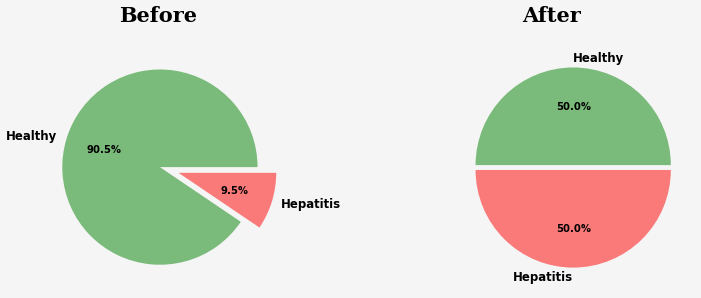

In [69]:
fig = plt.figure(figsize = (24,10), dpi = 60)
gs = GridSpec(ncols=13, nrows=5, left=0.05, right=0.5, wspace=0.2, hspace=0.1)
fig.patch.set_facecolor('#f5f5f5')
sns.set_palette(sns.color_palette(['green','purple', 'orange', 'red']))

ax1 = fig.add_subplot(gs[:, 0:5])
ax2 = fig.add_subplot(gs[:, 8:])

axes = [ax1,ax2]

for ax in axes:
    ax.axes.get_yaxis().set_visible(False)
    ax.set_facecolor('#f5f5f5')
    
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

#------------------------------------------------------------    
#ax1
ax1_plot = ax1.pie(y_train.value_counts().values, 
                   labels=['Healthy', 'Hepatitis'],
                    autopct='%1.1f%%', explode=[0.1,  0.1], 
                   colors=['green', 'red'])

for piece in ax1_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax1_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax1_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

    
fig.text(0.1, 0.75, 'Before',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25})
#------------------------------------------------------------    
#ax2
ax2_plot = ax2.pie(X_train.value_counts().values, 
                   labels=['Healthy', 'Hepatitis'],
                    autopct='%1.1f%%', explode=[0.05,  0], 
                   colors=['green', 'red'])

for piece in ax2_plot[0]:
    piece.set_alpha(0.5)

for i, text in enumerate(ax2_plot[1]):
    text.set_weight('bold')
    text.set_size(14)

for i, text in enumerate(ax2_plot[2]):
    text.set_weight('bold')
    text.set_size(12)

fig.text(0.38, 0.75, 'After',  {'font':'Serif', 'weight':'bold','color': 'black', 'size':25}) 

plt.show()

## Data Normalization

In [70]:
standard_sc = preprocessing.StandardScaler()

In [71]:
X_train = standard_sc.fit_transform(X_train)
X_test = standard_sc.transform(X_test)

## One Hot Encoding

In [72]:
X_train = np_utils.to_categorical(X_train, 2)
y_test = np_utils.to_categorical(y_test, 2)

## Bikin Model

In [73]:
clf = MLPClassifier(random_state = 46)
param = {
        "hidden_layer_sizes":[64,128,256],
        "activation":["identity", "logistic", "tanh", "relu"],
        'solver': ["lbfgs", "sgd", "adam"],
        "learning_rate":["constant", "invscaling", "adaptive"],
        'max_iter': [100,200],
        "warm_start":[True]
}

In [74]:
model = GridSearchCV(clf,param_grid=param, cv=3, n_jobs=-1)
model.fit(X_train, X_train)

GridSearchCV(cv=3, estimator=MLPClassifier(random_state=46), n_jobs=-1,
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [64, 128, 256],
                         'learning_rate': ['constant', 'invscaling',
                                           'adaptive'],
                         'max_iter': [100, 200],
                         'solver': ['lbfgs', 'sgd', 'adam'],
                         'warm_start': [True]})

In [75]:
print("Best params:")
print(json.dumps(model.best_params_, indent=4))
print("Best Score: "+str(model.best_score_)+'\n')

Best params:
{
    "activation": "relu",
    "hidden_layer_sizes": 128,
    "learning_rate": "constant",
    "max_iter": 100,
    "solver": "lbfgs",
    "warm_start": true
}
Best Score: 0.9866023232715809



### Validasi Model

In [76]:
y_test_pred = model.predict(X_test)

In [77]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       160
           1       1.00      0.94      0.97        17

   micro avg       0.99      0.99      0.99       177
   macro avg       1.00      0.97      0.98       177
weighted avg       0.99      0.99      0.99       177
 samples avg       0.99      0.99      0.99       177



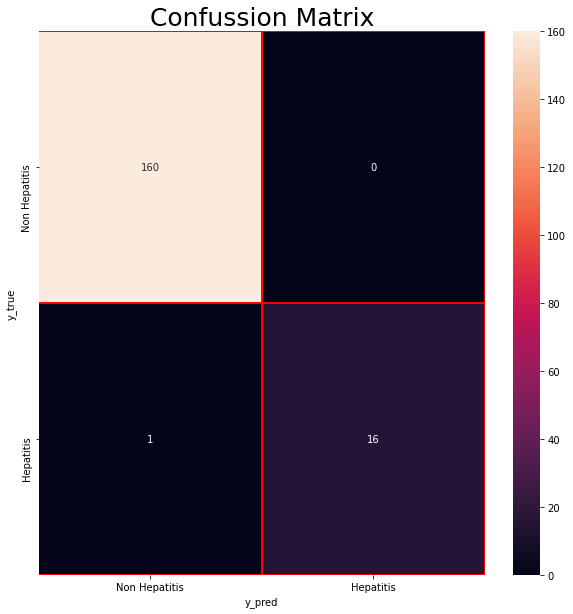

In [78]:
names = ['Non Hepatitis','Hepatitis']
cm = confusion_matrix(y_test.argmax(axis=1), y_test_pred.argmax(axis=1))
f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm,annot=True,linewidth=.5,linecolor="r",fmt=".0f",ax=ax)
plt.title("Confussion Matrix", size = 25)
plt.xlabel("y_pred")
plt.ylabel("y_true")
ax.set_xticklabels(names)
ax.set_yticklabels(names)

plt.show()